Loaded data file /Users/vigneshkumarthangarajan/Documents/255-Data-Mining/project/emailClassifyDMproject/all_data.csv with 36571 rows


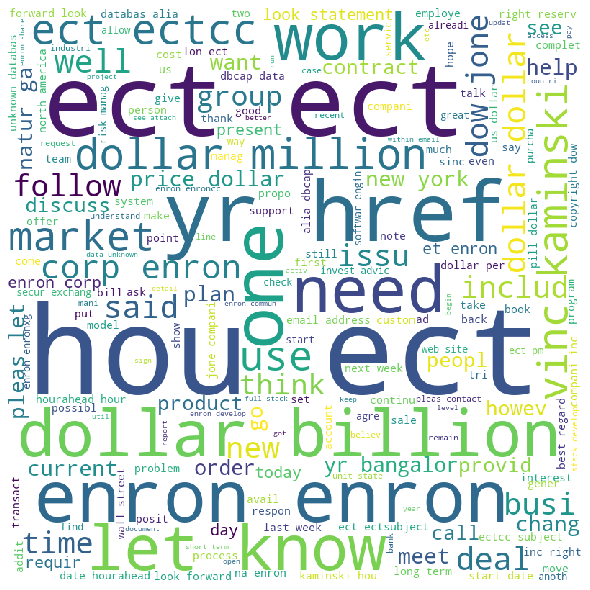

train words 208017
train len: 25599 test len: 10972
spam_cnt 12849
ham_cnt 12750
12750
false_positive 76
false_negative 1566
85.03463361283266


In [3]:
from countminsketch import CountMinSketch
from emailclass import Email
import csv
import random
from random import seed
import math
import sys
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import scattertext as st
import spacy
from pprint import pprint

filenames = ["spam_csv.csv", "ham_csv.csv", "ham_2.csv", "spam_2.csv"]

def createCloud(dt):
    comment_words =' '
    for i in range(len(dt)):
        row = dt[i]
        text = row[0]
        comment_words = comment_words + text + ' '
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                #stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

csv.field_size_limit(sys.maxsize)

def loadCsv(filename) -> [[]]:
    lines = csv.reader(open(filename, "r"))
    dataset = list(lines)
    r = 0
    dt = []
    for i in range(len(dataset)):
        if (i == 0):
            continue
        c = 0
        r+=1
        rows=[]
        for x in dataset[i]:
            if (c == 0):
                c+=1
                continue
            rows.append(x)
            c+=1
        dt.append(rows)
    print(('Loaded data file {0} with {1} rows').format(filename, len(dt)))
    return dt

def getUniquewords(dt):
    _set = set()
    for i in range(len(dt)):
        row = dt[i]
        text = row[0]
        ls = text.split()
        for word in ls:
            _set.add(word)
    return _set

def getWords(dt):
    _count = 0
    for i in range(len(dt)):
        row = dt[i]
        text = row[0]
        ls = text.split()
        for word in ls:
            _count += 1
    return _count

def splitDataset(dataset, splitRatio):
    trainSize = int(len(dataset) * splitRatio)
    trainSet = []
    copy = list(dataset)
    seed(1)
    while len(trainSet) < trainSize:
        index = random.randrange(len(copy))
        trainSet.append(copy.pop(index))
    return [trainSet, copy]

def accuracy(testSet, predictions):
    correct = 0
    false_positive = 0
    false_negative = 0
    for i in range(len(testSet)):
        if testSet[i][-1] == predictions[i]:
            correct += 1
        elif predictions[i] == "1":
            false_positive += 1
        elif predictions[i] == "0":
            false_negative += 1
    print("false_positive "+str(false_positive))
    print("false_negative "+str(false_negative))
    return (correct/float(len(testSet))) * 100.0

def buildCMS(dt, sketch):
    for i in range(len(dt)):
        row = dt[i]
        text = row[0]
        #text = text.encode('utf-8')
        ls = text.split()
        e = None
        for word in ls:
            e = Email(word,row[1])
            #print("hash: "+str(hash(e)))
            sketch.add(e)

def calcProb(test, testlen, sketch, spam_cnt, ham_cnt, pseudo_add):
    total_cnt = spam_cnt+ham_cnt
    prob_of_spam = spam_cnt/total_cnt
    prob_of_ham = ham_cnt/total_cnt
#    print("prob_of_spam "+str(prob_of_spam))
#    print("prob_of_ham "+str(prob_of_ham))
    vec = []
    for i in range(len(test)):
        row = test[i]
        text = row[0]
        ls = text.split()
        total_spam_prob = 1
        total_ham_prob = 1
        pseudo_add = 0
        for word in ls:
            pseudo_add+=1
        for word in ls:
            word_class_cnt = 0
            word_class_cnt = sketch[Email(word,"0")]
#            print(word+" "+str(word_class_cnt))
            #if (word_class_cnt == 0):
            #    word_class_cnt = 1;
            word_class_cnt += 1
            word_class_prob = word_class_cnt/(ham_cnt+pseudo_add)
            total_ham_prob *= word_class_prob
        for word in ls:
#            print(word+" "+str(word_class_cnt))
            word_class_cnt = 0
            word_class_cnt = sketch[Email(word,"1")]
            #if (word_class_cnt == 0):
            #    word_class_cnt = 1;
            word_class_cnt += 1
            word_class_prob = word_class_cnt/(spam_cnt+pseudo_add)
            total_spam_prob *= word_class_prob
#        print("total_spam_prob "+ str(total_spam_prob))
#        print("total_ham_prob "+ str(total_ham_prob))
        spam_prob = total_spam_prob*prob_of_spam
        ham_prob = total_ham_prob*prob_of_ham
#        print("ham_prob "+str(ham_prob))
#        print("spam_prob "+str(spam_prob))
        if (spam_prob > ham_prob):
            vec.append("1")
        else:
            vec.append("0")
    return vec

def createCSV():
    combined_csv = pd.concat([ pd.read_csv(f) for f in filenames ] )
    combined_csv = combined_csv.sample(frac=1).reset_index(drop=True) #this will shuffle the data set and reset the index.
    combined_csv.to_csv( "all_data.csv")

if (__name__ == '__main__'):
    dt = loadCsv("/Users/vigneshkumarthangarajan/Documents/255-Data-Mining/project/emailClassifyDMproject/all_data.csv")
    train, test = splitDataset(dt,0.7)
    createCloud(train)
    _tset = getUniquewords(train)
    print("train words "+str(len(_tset)))
    _count_test = getWords(test)
    print('train len: ' + str(len(train)) + ' test len: '+str(len(test)))
    trainlen = len(train)
    testlen = len(test)
    spam_cnt=0
    ham_cnt=0
    for i in range(trainlen):
        row = train[i]
        _class = row[1]
        if (_class == "1"):
            spam_cnt += 1
        else:
            ham_cnt += 1

    sketch = CountMinSketch(100000, 15) # 'w' and 'd' parameter for count-min sketch
    buildCMS(train, sketch)
    print("spam_cnt "+str(spam_cnt))
    print("ham_cnt "+str(ham_cnt))
    print(ham_cnt)
    pred_vec = calcProb(test, testlen, sketch, spam_cnt, ham_cnt, _count_test)
#    print(sketch.gettable())
    correct_cnt = 0
    inc_cnt = 0
#    print(test)
#    print(train)
    print(accuracy(test,pred_vec))

